# Count tangles on a slide

In [63]:
# Prelims
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.cuda as cutorch
import timeit
import scipy.special
import sys
import openslide
from scipy.ndimage import gaussian_filter

# Import wildcat
sys.path.append("wildcat.pytorch")
import wildcat.models

# Import wildcat mods
from unet_wildcat import *

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("CUDA status: ", torch.cuda.is_available())
print("CUDA memory max alloc: %8.f MB" % (torch.cuda.max_memory_allocated() / 2.0**20))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

PyTorch Version:  1.0.0
Torchvision Version:  0.2.2
CUDA status:  True
CUDA memory max alloc:     7111 MB
Device:  cuda:0


In [68]:
# Global properties
exp_dir = "/home/pyushkevich/data/dirwin/tdp/organize/exp01_tdp"
#exp_dir = "/home/pyushkevich/data/dirwin/dlb/organize/exp01_dlb"
num_classes=2
input_size=224
input_size_wildcat=224
batch_size=16
batch_size_wildcat=16
resnet_flavor=18
fold = "fold_INDD119294"
data_dir = os.path.join(exp_dir, "patches")
model_dir=os.path.join(exp_dir, "models")

# Size of the training patch used to train wildcat, in raw pixels
patch_size_raw = 224

# Size of the window used to apply WildCat. Should be larger than the patch size
# This does not include the padding
window_size_raw = 2240

In [69]:
# Read the wildcat model
model_wildcat = resnet50_wildcat_upsample(2, pretrained=False, kmax=0.02, alpha=0.7, num_maps=4)
model_wildcat.load_state_dict(torch.load(os.path.join(model_dir, "my_wildcat_50_30epoch_k02_upsample.dat")))

# Set evaluation mode
model_wildcat.eval()

# Send model to GPU
model_wildcat = model_wildcat.to(device)

In [ ]:
# Read a slide and show thumbnail
osl=openslide.OpenSlide('/home/pyushkevich/data/dirwin/tdp/raw_slides/2005-041-34F_HIP_TDP43MP_1K_07-31-19_RL.svs')
# osl=openslide.OpenSlide('/home/pyushkevich/data/dirwin/dlb/2014-070-32F_STC_SYN303_pyramidal.tiff')
plt.figure(figsize=(16,16))
plt.imshow(osl.get_thumbnail((512,512)), 
           extent=(0,osl.level_dimensions[0][0]/window_size_raw,osl.level_dimensions[0][1]/window_size_raw,0))
ax = plt.gca()
plt.xticks(np.arange(0,osl.level_dimensions[0][0]/window_size_raw));
plt.yticks(np.arange(0,osl.level_dimensions[0][1]/window_size_raw));

In [101]:

# The amount of padding, relative to patch size to add to the window. This padding
# is to provide context at the edges of the window
padding_size_rel = 1.0
padding_size_raw = int(padding_size_rel * patch_size_raw)

# Dimensions of the input image
slide_dim = np.array(osl.dimensions)

# Factor by which wildcat shrinks input images when mapping to segmentations
wildcat_shrinkage=2

# Additional shrinkage to apply to output (because we don't want to store very large)
# output images
extra_shrinkage=4

# Size of output pixel (in input pixels)
out_pix_size = wildcat_shrinkage * extra_shrinkage * patch_size_raw * 1.0 / input_size_wildcat

# The output size for each window
window_size_out = int(window_size_raw / out_pix_size)

# The padding size for the output
padding_size_out = int(padding_size_rel * patch_size_raw / out_pix_size)

# Total number of non-overlapping windows to process
n_win = np.ceil(slide_dim / window_size_raw).astype(int)

# Output image size 
out_dim=(n_win * window_size_out).astype(int)

# Output array (last dimension is per-class probabilities)
density=np.zeros((2, out_dim[0], out_dim[1]))

# Range of pixels to scan
# u_range,v_range = (3,36),(28,76)
u_range,v_range = (2,n_win[0]),(5,n_win[1])
# u_range,v_range = (0,n_win[0]),(0,n_win[1])

# Range non-overlapping windows
t_00 = timeit.default_timer()
for u in range(u_range[0], u_range[1]):
    for v in range(v_range[0], v_range[1]):
        
        # Get the coordinates of the window in raw pixels
        x,y,w = u*window_size_raw,v*window_size_raw,window_size_raw
        
        # Subtract the padding
        xp,yp,wp = x-padding_size_raw,y-padding_size_raw,window_size_raw+2*padding_size_raw
        
        # Read the chunk from the image
        t0 = timeit.default_timer()
        chunk_img=osl.read_region((xp,yp), 0, (wp,wp)).convert("RGB")
        t1 = timeit.default_timer()
                
        # Compute the desired size of input to wildcat
        wwc = int(wp * input_size_wildcat / patch_size_raw)

        # Resample the chunk for the two networks
        tran = transforms.Compose([
            transforms.Resize((wwc,wwc)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        # Convert the read chunk to tensor format
        with torch.no_grad():
            
            # Apply transforms and turn into correct-size torch tensor
            chunk_tensor=torch.unsqueeze(tran(chunk_img),dim=0).to(device)
            
            # Forward pass through the wildcat model
            x_clas = model_wildcat.forward_to_classifier(chunk_tensor)
            x_cpool = model_wildcat.spatial_pooling.class_wise(x_clas)

            # Scale the cpool image to desired size
            x_cpool_up = torch.nn.functional.interpolate(x_cpool, scale_factor=1.0/extra_shrinkage).detach().cpu().numpy()

            # Extract the central portion of the output
            p0,p1 = padding_size_out,(padding_size_out+window_size_out)
            x_cpool_ctr = x_cpool_up[:,:,p0:p1,p0:p1]
            
            # Stick it into the output array
            xout0,xout1 = u * window_size_out, ((u+1) * window_size_out)
            yout0,yout1 = v * window_size_out, ((v+1) * window_size_out)
            density[0,xout0:xout1,yout0:yout1] = x_cpool_ctr[0,0,:,:].transpose()
            density[1,xout0:xout1,yout0:yout1] = x_cpool_ctr[0,1,:,:].transpose()
                
        # Finished first pass through the chunk
        t2 = timeit.default_timer()
        
        # At this point we have a list of hits for this chunk
        print("Chunk: (%6d,%6d) Times: IO=%6.4f WldC=%6.4f Totl=%8.4f" %
              (u,v,t1-t0,t2-t1,t2-t0))
        
# Trim the density array to match size of input
out_dim_trim=np.round((slide_dim/out_pix_size)).astype(int)
density=density[:,0:out_dim_trim[0],0:out_dim_trim[1]]

Chunk: (     2,     5) Times: IO=0.8555 WldC=0.9902 Totl=  1.8456
Chunk: (     2,     6) Times: IO=0.8563 WldC=0.9898 Totl=  1.8461
Chunk: (     2,     7) Times: IO=0.8485 WldC=0.9885 Totl=  1.8370
Chunk: (     2,     8) Times: IO=0.8422 WldC=0.9891 Totl=  1.8313
Chunk: (     2,     9) Times: IO=0.8357 WldC=0.9809 Totl=  1.8165
Chunk: (     2,    10) Times: IO=0.8410 WldC=0.9894 Totl=  1.8305
Chunk: (     2,    11) Times: IO=0.8372 WldC=0.9868 Totl=  1.8240
Chunk: (     2,    12) Times: IO=0.8309 WldC=0.9887 Totl=  1.8196
Chunk: (     2,    13) Times: IO=0.8422 WldC=0.9889 Totl=  1.8311
Chunk: (     2,    14) Times: IO=0.8801 WldC=0.9886 Totl=  1.8687
Chunk: (     2,    15) Times: IO=0.8398 WldC=0.9867 Totl=  1.8265
Chunk: (     2,    16) Times: IO=0.8297 WldC=0.9846 Totl=  1.8143
Chunk: (     2,    17) Times: IO=0.8428 WldC=0.9923 Totl=  1.8351
Chunk: (     2,    18) Times: IO=0.0666 WldC=0.9848 Totl=  1.0515
Chunk: (     3,     5) Times: IO=0.8617 WldC=0.9918 Totl=  1.8535
Chunk: (  

In [59]:
# Compute the default v_range
v_range_def = (-12,12)

# A function to plot a region of the histology image and corresponding tangle prediction
def plot_classification_region(u0,v0,u1,v1,d_sample,vrange=v_range_def,sigma=0,show_ticks=True):
    # The image region
    img_rgn=osl.read_region((u0,v0), d_sample,
                            (int((u1-u0)/osl.level_downsamples[d_sample]),
                             int((v1-v0)/osl.level_downsamples[d_sample])))
    
    # The tangle map
    o_u0 = int(u0 / out_pix_size)
    o_v0 = int(v0 / out_pix_size)
    o_u1 = int(u1 / out_pix_size)
    o_v1 = int(v1 / out_pix_size)
    t_map=density[1,o_u0:o_u1,o_v0:o_v1].transpose()-density[0,o_u0:o_u1,o_v0:o_v1].transpose()
    t_map=np.where(t_map > 0, t_map, 0)
    
    # Smooth the tangle map
    t_map = gaussian_filter(t_map, sigma)
    
    # Create plots side by side
    fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(20,10))
    
    # Plot the image region
    ax[0].imshow(img_rgn, extent=(u0,u1,v1,v0))
    ax[0].grid(color='black', linestyle='-', linewidth=0.5)
    cs=ax[1].imshow(t_map, plt.get_cmap("jet"), vmin=vrange[0], vmax=vrange[1], extent=(u0,u1,v1,v0))
    ax[1].grid(color='black', linestyle='-', linewidth=0.5)
    # ax[1].colorbar(cs)
    if show_ticks is False:
        ax[0].xaxis.set_ticklabels([])
        ax[1].xaxis.set_ticklabels([])
        ax[0].yaxis.set_ticklabels([])
        ax[1].yaxis.set_ticklabels([])
    fig.show()

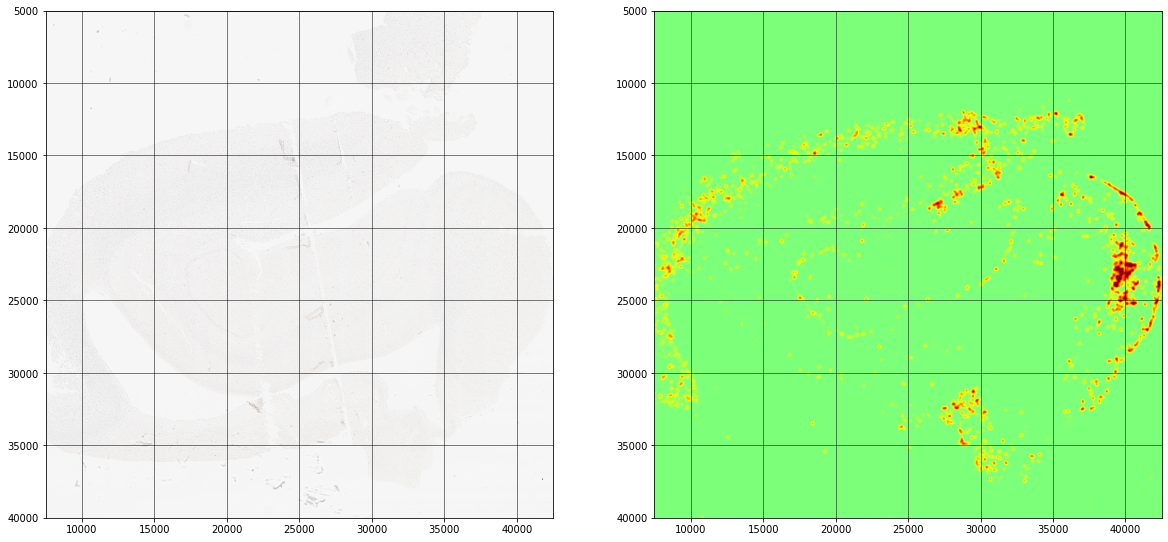

In [112]:
plot_classification_region(7500,5000,42500,40000,2,(-3,3),10, show_ticks=True)
#plot_classification_region(0,0,slide_dim[0],slide_dim[1],6)

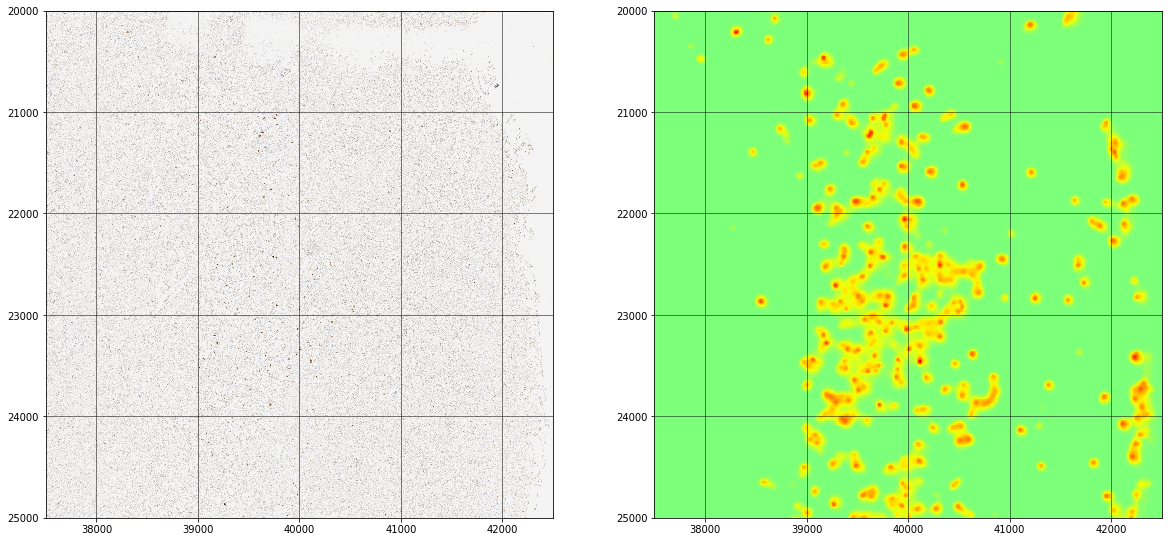

In [115]:
plot_classification_region(37500,20000,42500,25000,0,(-12,12),2)
#plot_classification_region(40000,130000,60000,150000,4,(-.4,.4),20, show_ticks=False)


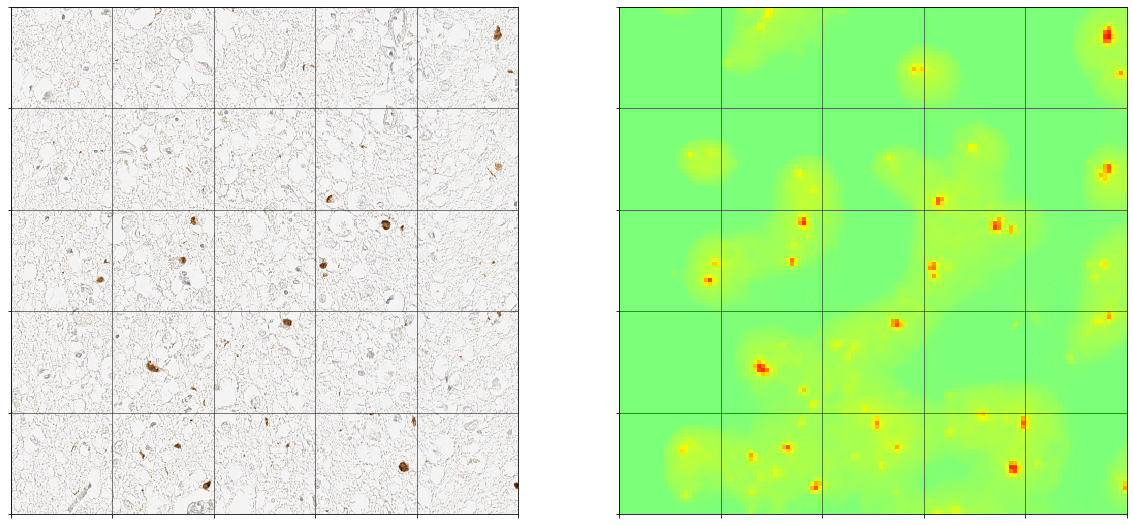

In [121]:
plot_classification_region(39000,22000,40000,23000,0,(-32,32),0, show_ticks=False)
#plot_classification_region(52500,142500,55000,145000,2,(-8,8),1, show_ticks=False)

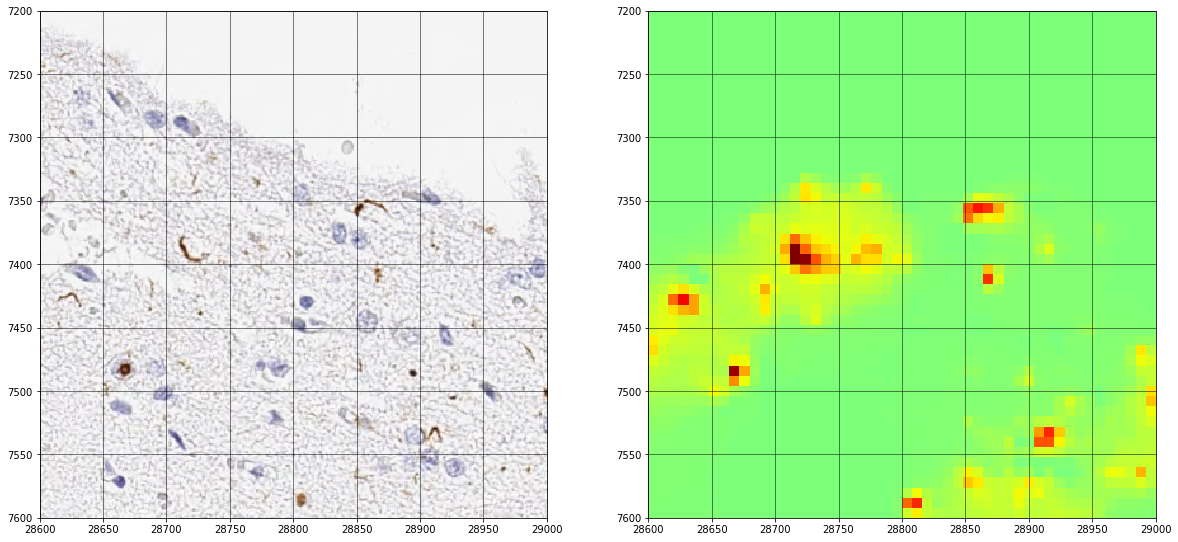

In [95]:
plot_classification_region(28600,7200,29000,7600,0)